# Determination of lightning length from light curves

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 

/storage/experiments/2021/0605_bourka_radosovice 5


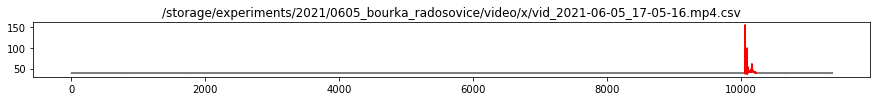

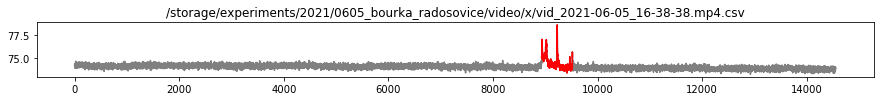

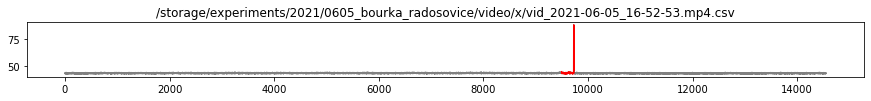

/storage/experiments/2021/0609_bourka_sobeslav 5


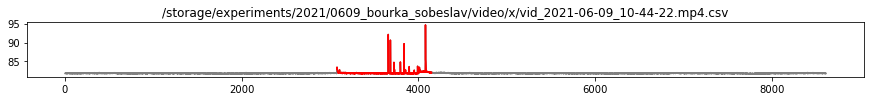

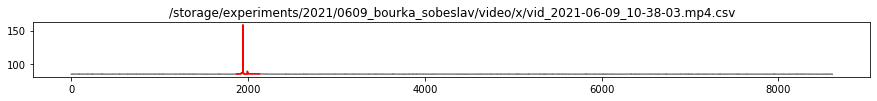

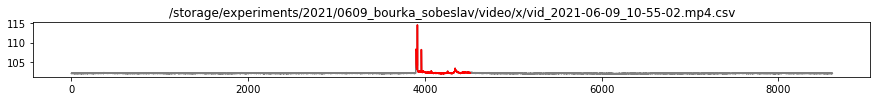

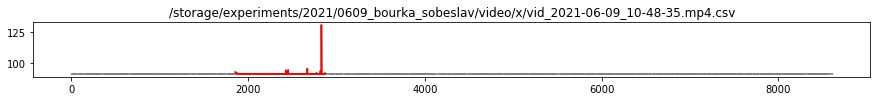

/storage/experiments/2021/0711_bourka_stiavnica 5


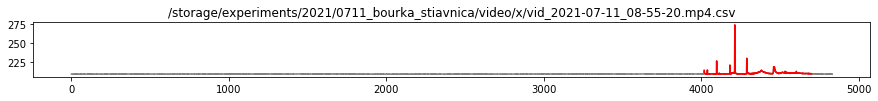

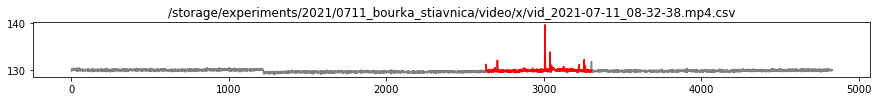

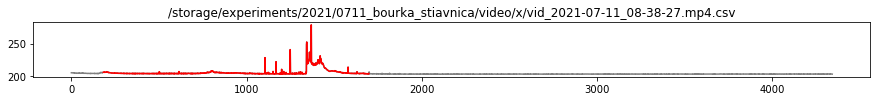

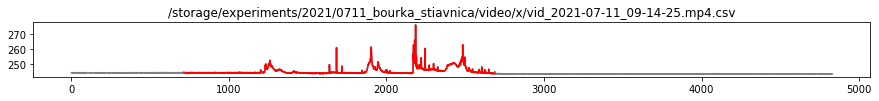

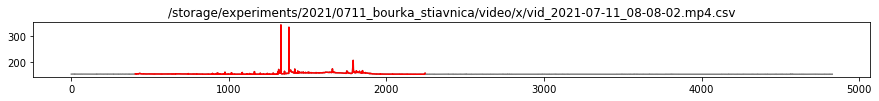

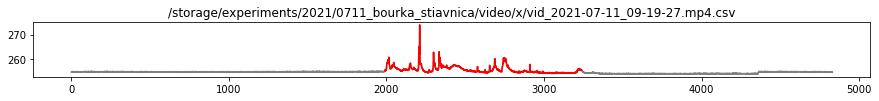

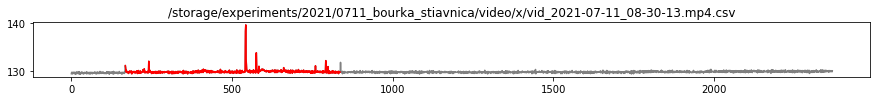

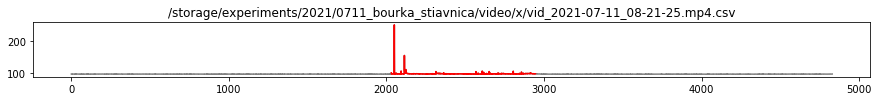

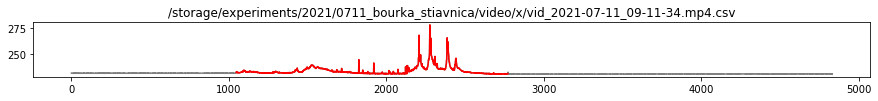

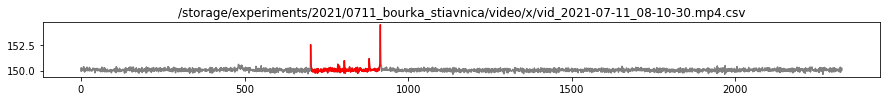

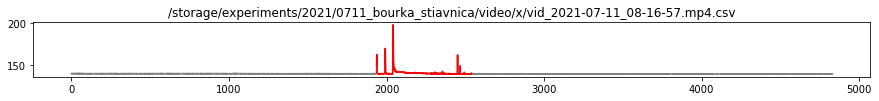

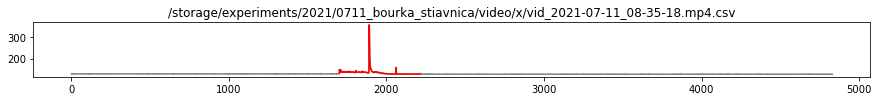

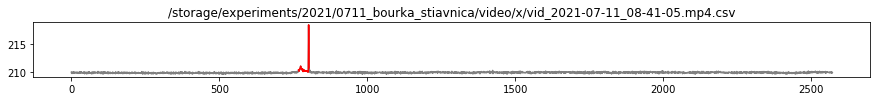

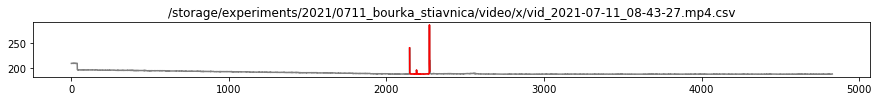

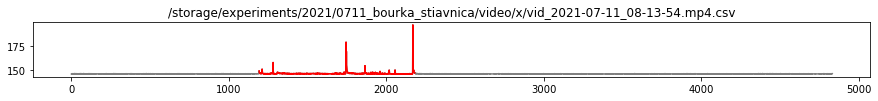

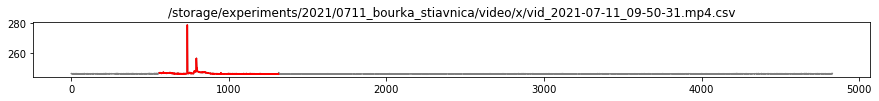

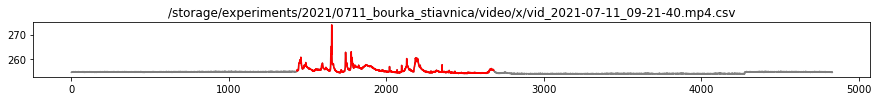

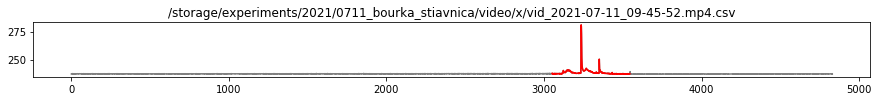

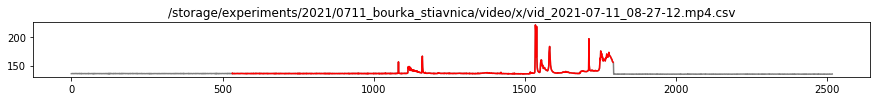

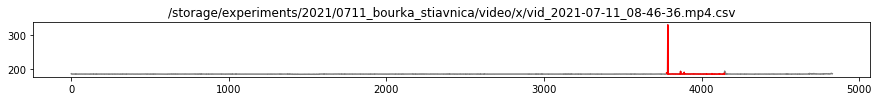

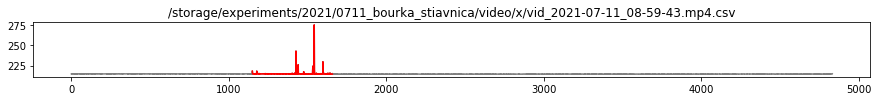

/storage/experiments/2021/0714_bourka_martin 5


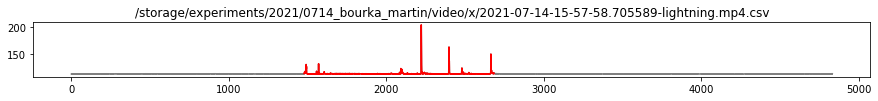

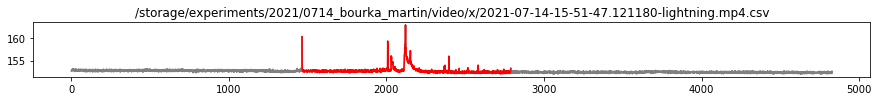

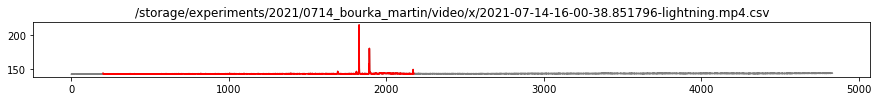

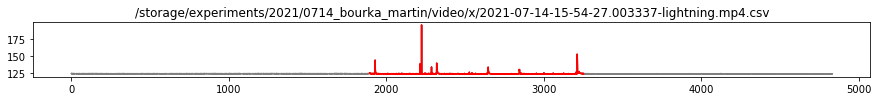

/storage/experiments/2021/0714_bourka_sobeslav 5


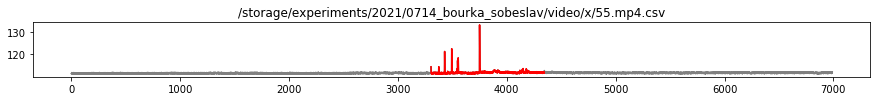

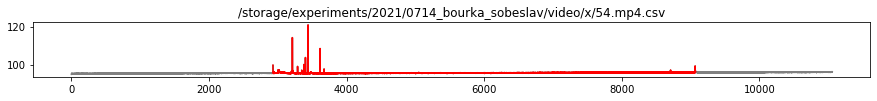

/storage/experiments/2021/0725_bourka_ratmirov 5


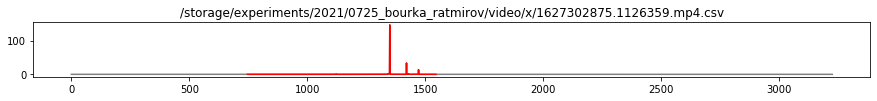

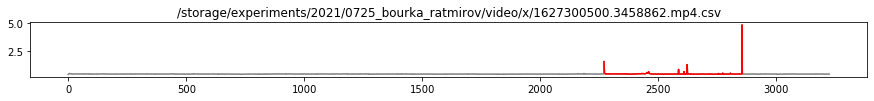

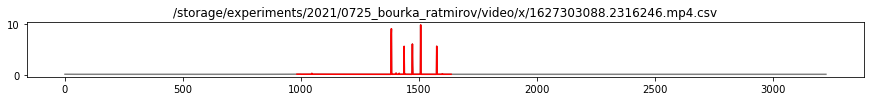

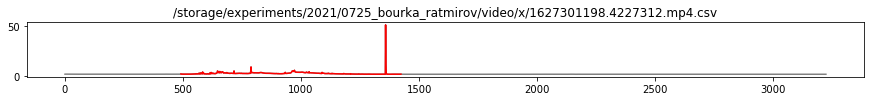

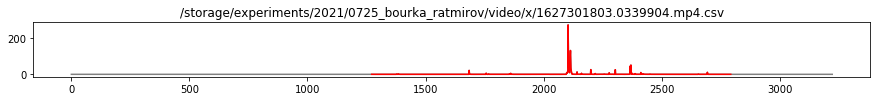

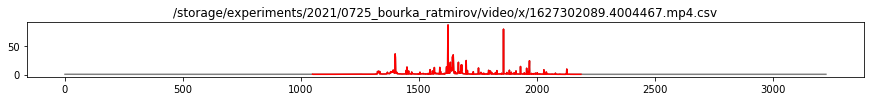

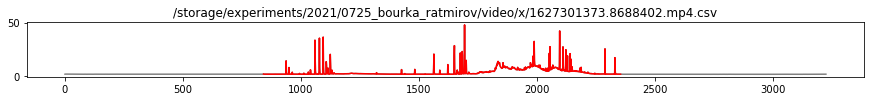

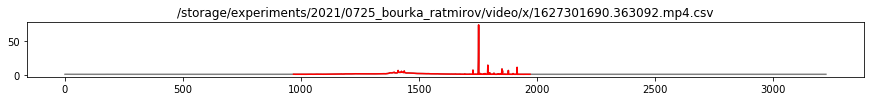

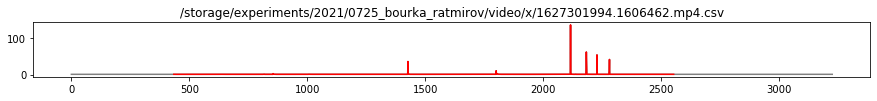

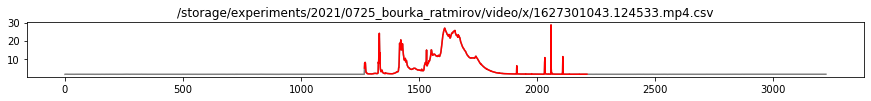

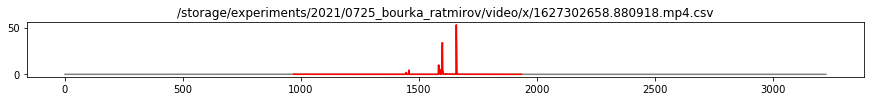

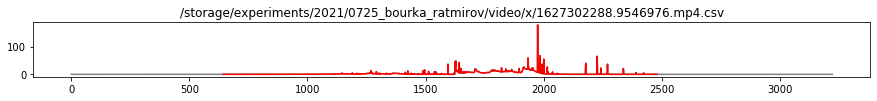

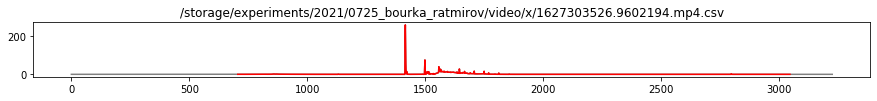

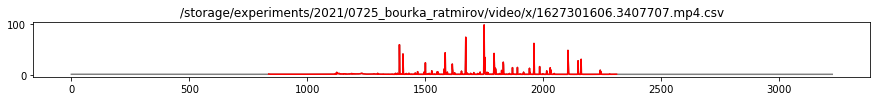

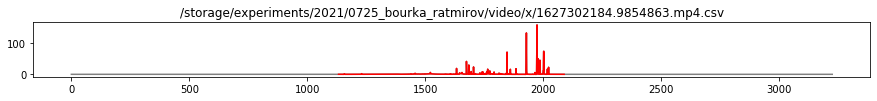

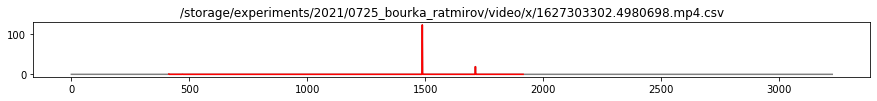

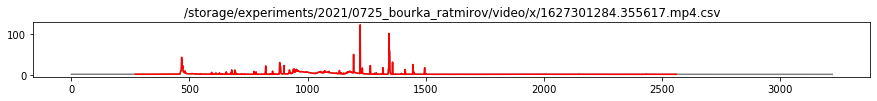

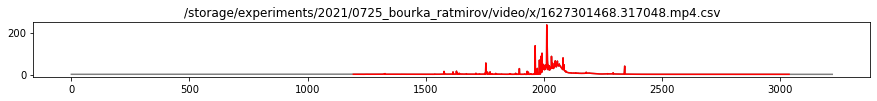

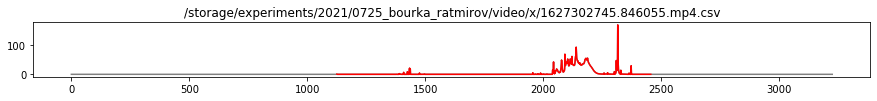

/storage/experiments/2021/0726_bourka_zabori 5


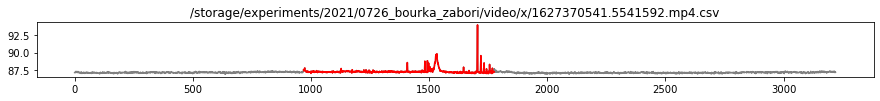

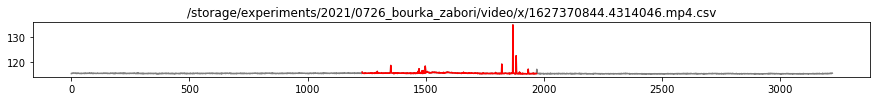

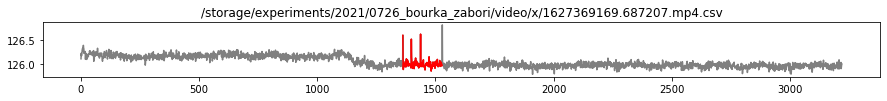

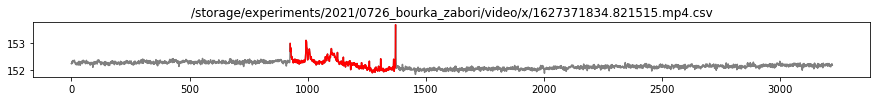

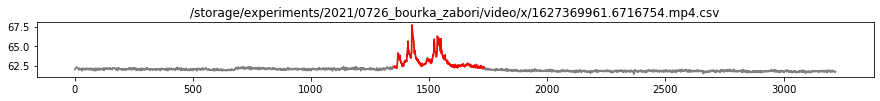

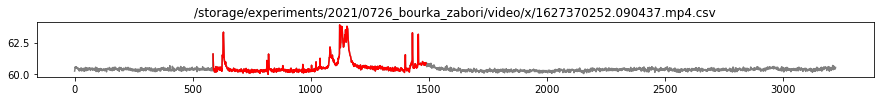

/storage/experiments/2021/0803_bourka_votice 5
/storage/experiments/2021/0807_bourka_sobeslav 5


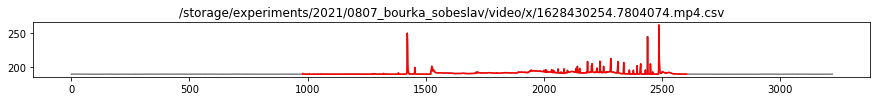

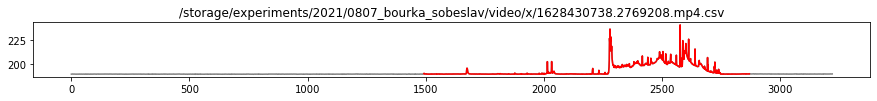

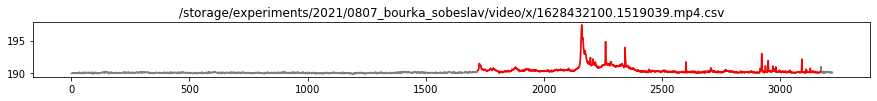

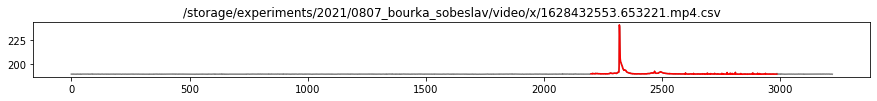

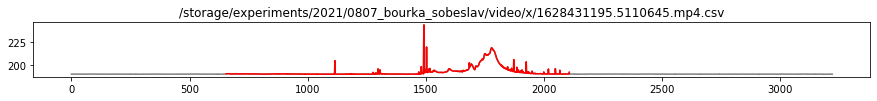

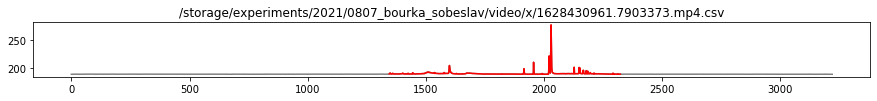

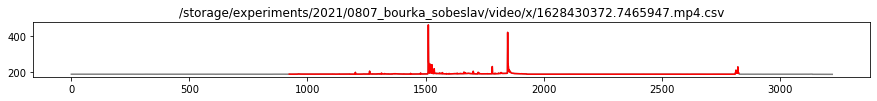

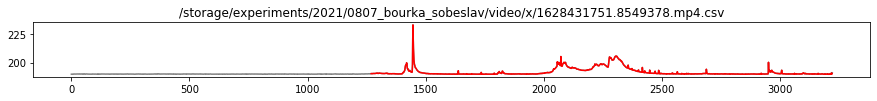

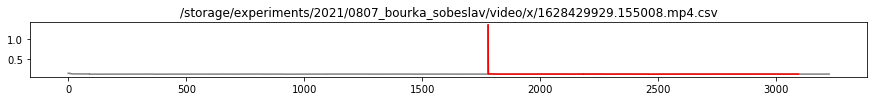

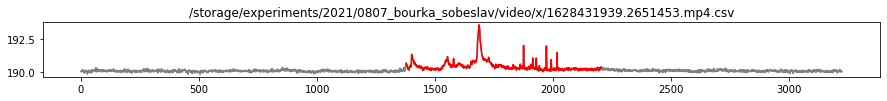

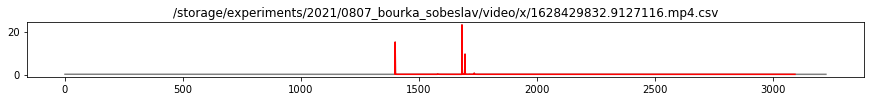

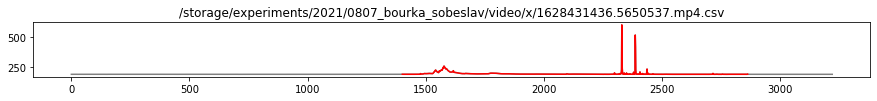

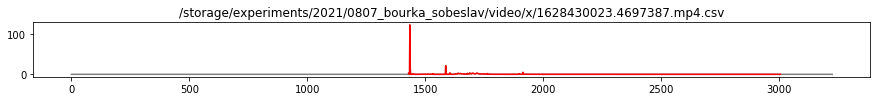

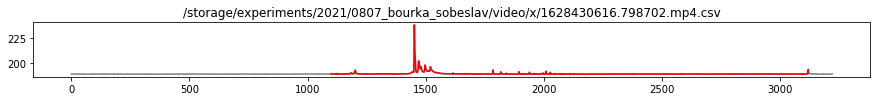

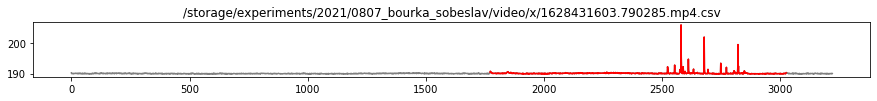

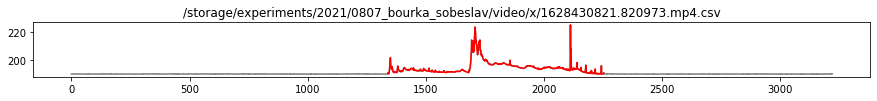

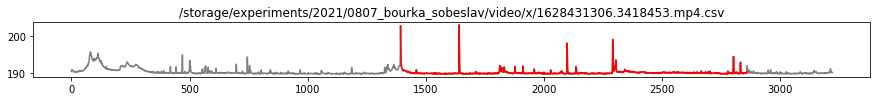

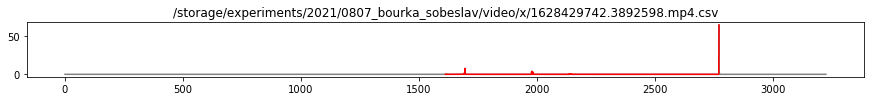

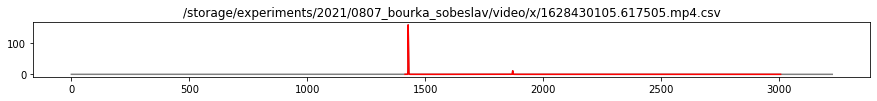

/storage/experiments/2021/0815_bourka_veseli_auto1 5


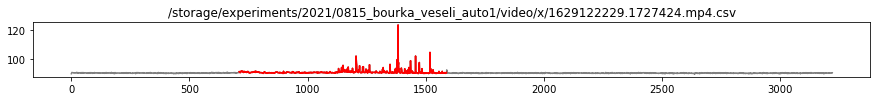

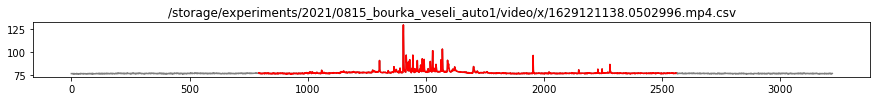

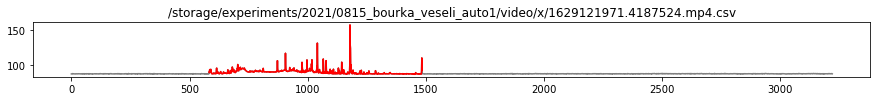

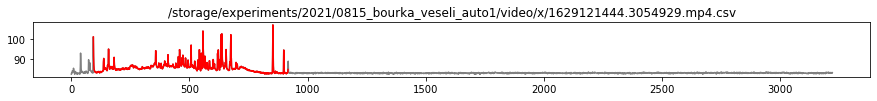

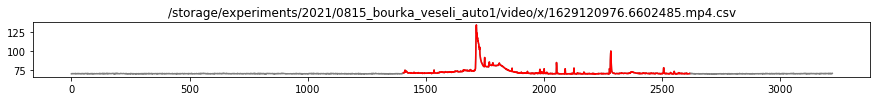

/storage/experiments/2021/0815_bourka_veseli_auto0 5


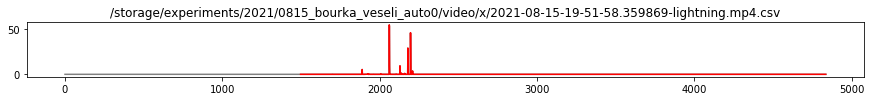

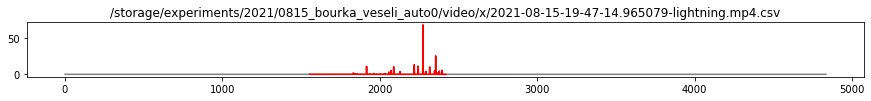

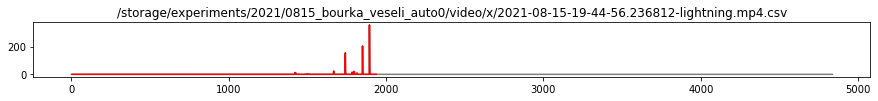

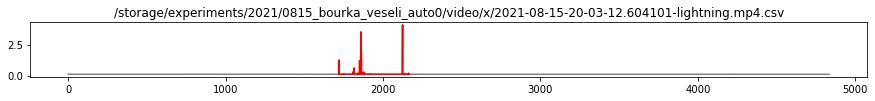

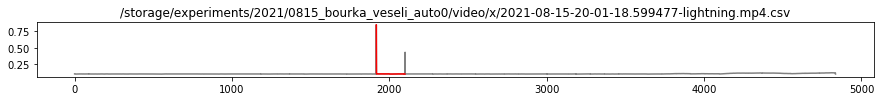

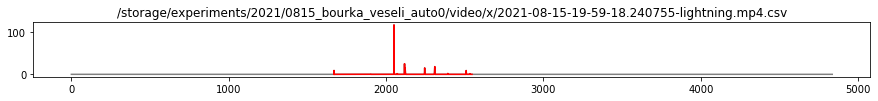

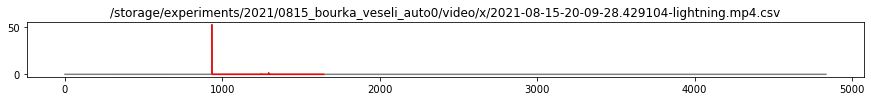

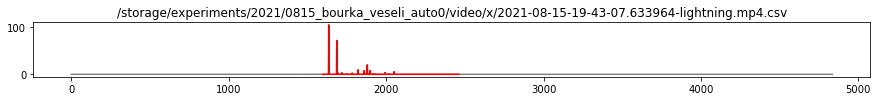

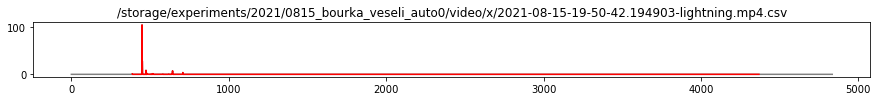

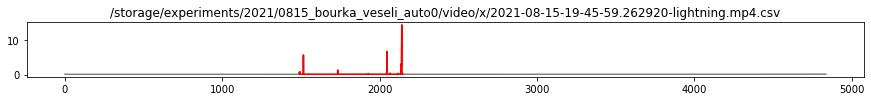

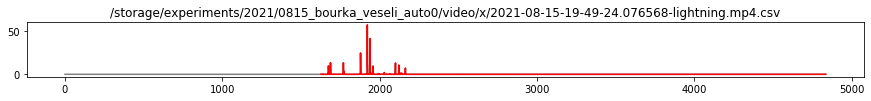

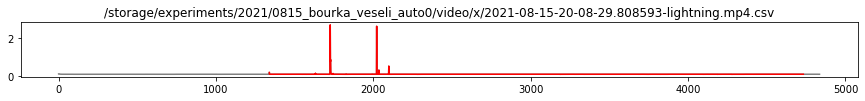

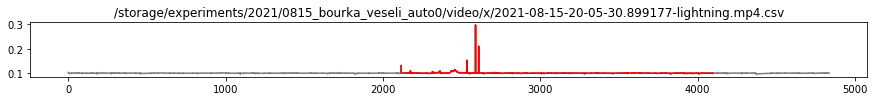

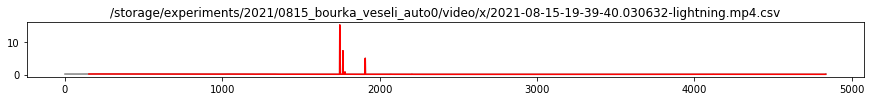

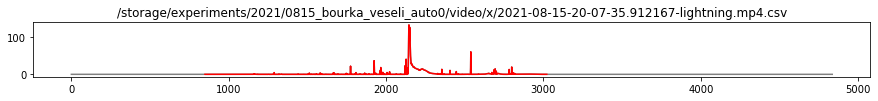

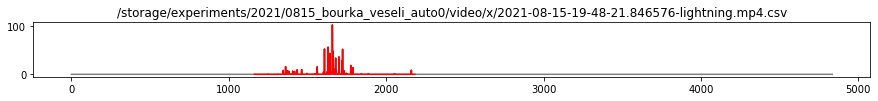

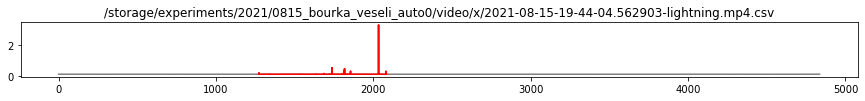

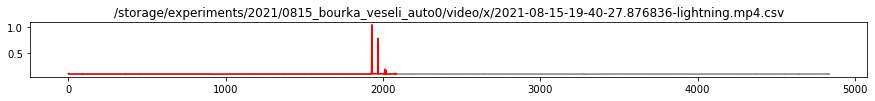

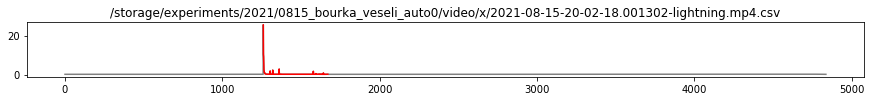

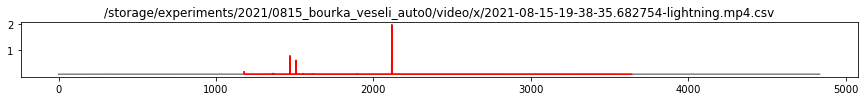

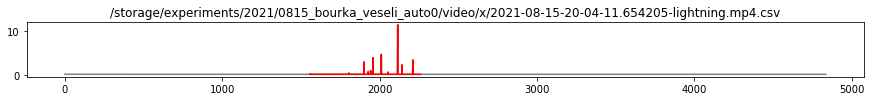

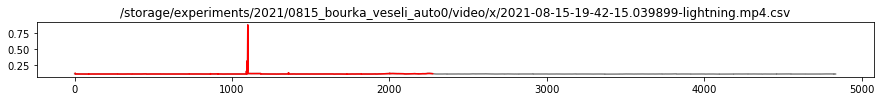

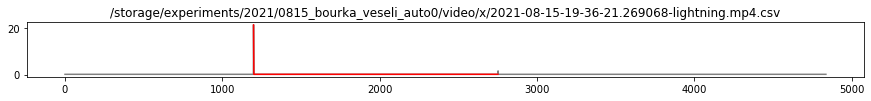

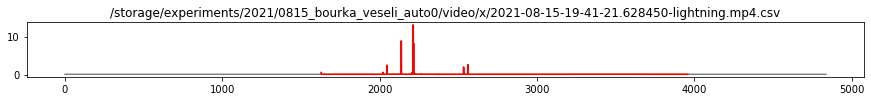

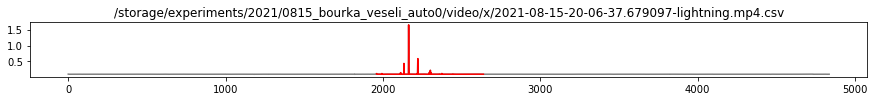

/storage/experiments/2021/0816_bourka_sobeslav 5


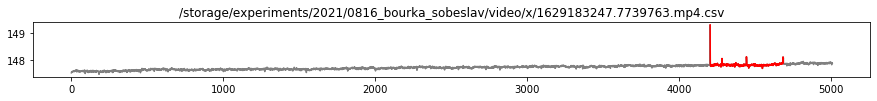

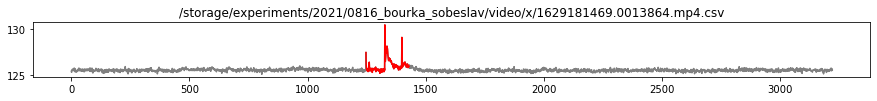

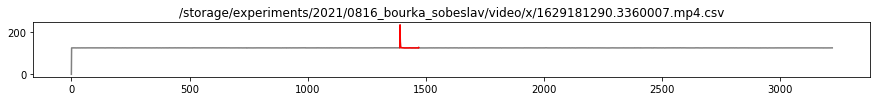

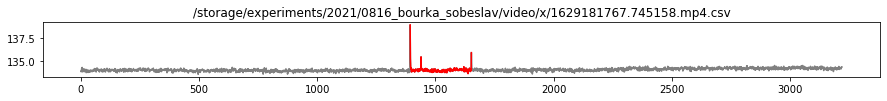

/storage/experiments/2021/0822_bourka_sobeslav_auto0 5


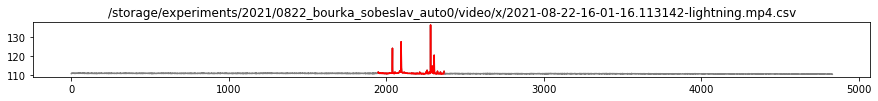

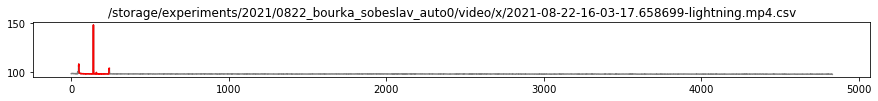

,name,width,height,frames,event_end,event_frames,event_length,event_start
0,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14549,10231.0,170.0,0.096042,10061.0
1,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9520.0,590.0,0.333323,8930.0
2,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9732.0,237.0,0.133894,9495.0
3,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8611,4149.0,1073.0,0.373619,3076.0
4,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8612,2130.0,256.0,0.089139,1874.0
...,...,...,...,...,...,...,...,...
109,/storage/experiments/2021/0816_bourka_sobeslav...,0,0,0,1430.0,183.0,0.113497,1247.0
110,/storage/experiments/2021/0816_bourka_sobeslav...,0,0,0,1471.0,81.0,0.050236,1390.0
111,/storage/experiments/2021/0816_bourka_sobeslav...,0,0,0,1653.0,260.0,0.161252,1393.0
112,/storage/experiments/2021/0822_bourka_sobeslav...,0,0,0,2368.0,420.0,0.260484,1948.0


In [42]:
'''
d = [{'dir':"/storage/experiments/2021/0605_bourka_radosovice",'threshold':5},\
{'dir':"/storage/experiments/2021/0711_bourka_stiavnica",'threshold':5}
#"/storage/experiments/2021/0713_bourka_exit29_D8",\
#"/storage/experiments/2021/0609_bourka_sobeslav"]
#"/storage/experiments/2021/0713_bourka_exit29_D8",\ # stroboskopicka bourka, nelze rozlisit jednotlive blesky
    ]
'''
d = [\
{'dir':"/storage/experiments/2021/0605_bourka_radosovice",'threshold':5},\
{'dir':"/storage/experiments/2021/0609_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0711_bourka_stiavnica",'threshold':5},\
{'dir':"/storage/experiments/2021/0714_bourka_martin",'threshold':5},\
{'dir':"/storage/experiments/2021/0714_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0725_bourka_ratmirov",'threshold':5},\
{'dir':"/storage/experiments/2021/0726_bourka_zabori",'threshold':5},\
{'dir':"/storage/experiments/2021/0803_bourka_votice",'threshold':5},\
{'dir':"/storage/experiments/2021/0807_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0815_bourka_veseli_auto1",'threshold':5},\
{'dir':"/storage/experiments/2021/0815_bourka_veseli_auto0",'threshold':5},\
{'dir':"/storage/experiments/2021/0816_bourka_sobeslav",'threshold':5},\
{'dir':"/storage/experiments/2021/0822_bourka_sobeslav_auto0",'threshold':5}]
#'''

files = pd.DataFrame( columns=['name', 'width', 'height', 'frames'])

window_size = 100
#threshold = 5

for directory in d:
    print(directory['dir'],directory['threshold'])

    for f in glob.iglob(directory['dir'] + "/video/x/*.csv"): # generator, search immediate subdirectories 
        s = f.split('/')
        st = s[len(s)-1]
        ss = f.split('.')
        sss= (ss[0]+'.'+ss[1]).split('/x')
        ff = sss[0]+sss[1]
        
        threshold = directory['threshold'] 
        
        # Import light curve
        light_curve = pd.read_csv(f, names = ['frame','illuminance'], header=0)
        #print(len(light_curve))

        vcap = cv2.VideoCapture(ff)
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        video_length = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        signal_samples=light_curve[["illuminance"]].to_numpy()
        if len(signal_samples) > 0:
            start_sample = signal_samples[:window_size]
            start_noise_std = np.nanstd(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            start_noise_mean = np.nanmean(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            
            end_sample = signal_samples[-window_size:]
            end_noise_std = np.nanstd(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            end_noise_mean = np.nanmean(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            #!!!print(start_noise_std, start_noise_mean, end_noise_std,end_noise_mean)


            for sample_num in range(0,len(signal_samples)):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / start_noise_std
                if z_score > threshold:
                    event_start = sample_num
                    break

            for sample_num in reversed(range(0,len(signal_samples))):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / end_noise_std
                if z_score > threshold:
                    event_end = sample_num
                    break
                    
            if (width == 1024): 
                frame_duration = 1/1770.0525
            if (width == 800): 
                frame_duration = 1/2871.9127
            if (width == 928): 
                frame_duration = 1/1612.3831
            #print(width)
            event_frames = event_end - event_start
            event_length = event_frames * frame_duration
            try:
                plt.figure(figsize=(15,1))
                #plt.tight_layout()
                plt.plot(signal_samples,c='gray')
                plt.plot(range(event_start,event_end), signal_samples[event_start:event_end],c='red')
                plt.title(f)
                plt.show()
            except:
                pass

        else:
            event_start = float("NaN")
            event_end = float("NaN")
        
        #print(f, ',', int(width), ',', int(height), ',', video_length)
        files = files.append({'name':f, 'width':int(width), 'height':int(height), 'frames':video_length, 'event_start':event_start, 'event_end':event_end, 'event_frames':event_frames, 'event_length':event_length}, ignore_index=True)
        vcap.release()
files

Text(0, 0.5, 'Events [-]')

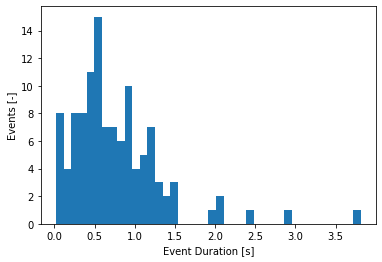

In [79]:
plt.hist(files['event_length'], bins=40)
plt.xlabel('Event Duration [s]')
plt.ylabel('Events [-]')

In [34]:
'''
d = ["/storage/experiments/2021/0605_bourka_radosovice",\
"/storage/experiments/2021/0711_bourka_stiavnica",\
"/storage/experiments/2021/0713_bourka_exit29_D8",\
"/storage/experiments/2021/0609_bourka_sobeslav"]
#"/storage/experiments/2021/0713_bourka_exit29_D8",\ # stroboskopicka bourka, nelze rozlisit jednotlive blesky

'''
d = ["/storage/experiments/2021/0605_bourka_radosovice",\
"/storage/experiments/2021/0609_bourka_sobeslav",\
"/storage/experiments/2021/0711_bourka_stiavnica",\
"/storage/experiments/2021/0714_bourka_martin",\
"/storage/experiments/2021/0714_bourka_sobeslav",\
"/storage/experiments/2021/0725_bourka_ratmirov",\
"/storage/experiments/2021/0726_bourka_zabori",\
"/storage/experiments/2021/0803_bourka_votice",\
"/storage/experiments/2021/0807_bourka_sobeslav",\
"/storage/experiments/2021/0815_bourka_veseli_auto1",\
"/storage/experiments/2021/0815_bourka_veseli_auto0",\
"/storage/experiments/2021/0816_bourka_sobeslav",\
"/storage/experiments/2021/0822_bourka_sobeslav_auto0"]
#'''

files = pd.DataFrame( columns=['name', 'width', 'height', 'frames'])

window_size = 100
threshold = 5

for directory in d:
    print(directory)

    for f in glob.iglob(directory + "/video/*.mp4"): # generator, search immediate subdirectories 
        s = f.split('/')
        st = s[len(s)-1]
        
        # Import light curve
        light_curve = pd.read_csv(f+'.csv', names = ['frame','illuminance'], header=0)
        #print(len(light_curve))

        vcap = cv2.VideoCapture(f)
        width  = vcap.get(3)  # float `width`
        height = vcap.get(4)  # float `height`
        video_length = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        signal_samples=light_curve[["illuminance"]].to_numpy()
        if len(signal_samples) > 0:
            start_sample = signal_samples[:window_size]
            start_noise_std = np.nanstd(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            start_noise_mean = np.nanmean(np.where(np.isclose(start_sample,0), np.nan, start_sample))
            
            end_sample = signal_samples[-window_size:]
            end_noise_std = np.nanstd(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            end_noise_mean = np.nanmean(np.where(np.isclose(end_sample,0), np.nan, end_sample))
            #print(start_noise_std, start_noise_mean, end_noise_std,end_noise_mean)


            for sample_num in range(0,len(signal_samples)):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / start_noise_std
                if z_score > threshold:
                    event_start = sample_num
                    break

            for sample_num in reversed(range(0,len(signal_samples))):
                signal_mean =((end_noise_mean-start_noise_mean)/len(signal_samples))*sample_num + start_noise_mean
                z_score = (signal_samples[sample_num] - signal_mean) / end_noise_std
                if z_score > threshold:
                    event_end = sample_num
                    break
            '''
            try:
                plt.figure(figsize=(15,1))
                plt.tight_layout()
                plt.plot(signal_samples,c='gray')
                plt.plot(range(event_start,event_end), signal_samples[event_start:event_end],c='red')
                plt.show()
            except:
                pass
            '''

        else:
            event_start = float("NaN")
            event_end = float("NaN")
        
        #print(f, ',', int(width), ',', int(height), ',', video_length)
        files = files.append({'name':f, 'width':int(width), 'height':int(height), 'frames':video_length, 'event_start':event_start, 'event_end':event_end}, ignore_index=True)
        vcap.release()
files

/storage/experiments/2021/0605_bourka_radosovice
/storage/experiments/2021/0609_bourka_sobeslav
/storage/experiments/2021/0711_bourka_stiavnica
/storage/experiments/2021/0714_bourka_martin
/storage/experiments/2021/0714_bourka_sobeslav
/storage/experiments/2021/0725_bourka_ratmirov
/storage/experiments/2021/0726_bourka_zabori
/storage/experiments/2021/0803_bourka_votice
/storage/experiments/2021/0807_bourka_sobeslav
/storage/experiments/2021/0815_bourka_veseli_auto1
/storage/experiments/2021/0815_bourka_veseli_auto0
/storage/experiments/2021/0816_bourka_sobeslav
/storage/experiments/2021/0822_bourka_sobeslav_auto0


,name,width,height,frames,event_end,event_start
0,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9732.0,9495.0
1,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9520.0,8930.0
2,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14549,11421.0,1055.0
3,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8612,4516.0,3898.0
4,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8611,4149.0,3076.0
...,...,...,...,...,...,...
191,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4832,1649.0,485.0
192,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4833,1683.0,462.0
193,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4832,1683.0,462.0
194,/storage/experiments/2021/0822_bourka_sobeslav...,0,0,0,NaN,NaN


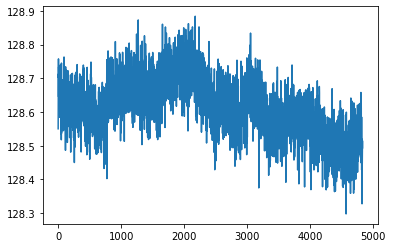

In [83]:
plt.plot(light_curve['frame'],light_curve['illuminance'])

In [84]:
light_curve

,frame,illuminance
0,0,128.550090
1,1,128.662144
2,2,128.653799
3,3,128.712568
4,4,128.702863
...,...,...
4828,4828,128.450104
4829,4829,128.477717
4830,4830,128.483539
4831,4831,128.514541


In [85]:
files

,name,width,height,frames,event_end,event_start
0,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9732.0,9495.0
1,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14550,9918.0,8930.0
2,/storage/experiments/2021/0605_bourka_radosovi...,1024,768,14549,11421.0,10061.0
3,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8612,7371.0,3898.0
4,/storage/experiments/2021/0609_bourka_sobeslav...,800,600,8611,4125.0,3076.0
...,...,...,...,...,...,...
201,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4832,2366.0,485.0
202,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4833,4277.0,1115.0
203,/storage/experiments/2021/0822_bourka_sobeslav...,928,928,4832,4277.0,1457.0
204,/storage/experiments/2021/0822_bourka_sobeslav...,0,0,0,NaN,NaN
